In [1]:
# Time each cell
%load_ext autotime

In [2]:
import os

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
from glob import glob

from tqdm import tqdm_notebook

import concurrent.futures

import ipywidgets as widgets

import numpy as np
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from photutils import find_peaks

from copy import copy

from piaa.utils.helpers import get_star_info, get_observation_blobs, \
    get_header, get_psc, show_stamps, normalize, get_sum, \
    get_ideal_full_coeffs, get_ideal_full_psc, get_vary, animate_stamp
from piaa.utils import images as img_utils
from piaa import exoplanets
from piaa.observation import Observation
from pocs.utils.images import fits as fits_utils

palette = copy(plt.cm.inferno)
palette.set_over('w', 1.0)
palette.set_under('k', 1.0)
palette.set_bad('g', 1.0)

time: 2.33 s


In [3]:
# A generic mask for the RGGB bayer pattern
rgb_masks = np.load('/var/panoptes/PIAA/rgb_masks.npz')

time: 3.79 ms


In [4]:
# Select the directory corresponding to an observation

# seq_id = 'PAN006/HatP30/7bab97/20180122T022948'
# seq_id = 'PAN006/HatP30/7bab97/20180122T022948'
# seq_id = 'PAN001/Wasp43/14d3bd/20180307T081001'
# seq_id = 'PAN006/HatP20/6575fc/20180202T233743'
# seq_id = 'PAN001/HatP20/14d3bd/20180202T061353'
# seq_id = 'PAN006/Hd189733/7bab97/20180327T071126'
seq_id = 'PAN001/Wasp43/14d3bd/20180116T093353'
# seq_id = 'PAN001/Wasp33/14d3bd/20160911T095804'
# seq_id = 'PAN006/Wasp104/7bab97/20180119T051913'
# seq_id = 'PAN006/HatP20/7bab97/20180126T233158'

time: 2.53 ms


In [5]:
working_dir = '/var/panoptes/processed/{}'.format(seq_id.replace('/', '_'))
# stamp_dir = os.path.join(working_dir, 'psc_{}'.format(stamp_size))
obs_dir = '/var/panoptes/images/fields/{}'.format(seq_id.replace('PAN001', ''))

time: 1.25 ms


In [7]:
observation = Observation(obs_dir, verbose=True)

********************************************************************************
Setting up Observation for analysis
Creating data cube......Done
time: 19.1 s


In [8]:
os.environ['PGPASSWORD'] = 'pan0pt3&-t3ss'

time: 1.1 ms


In [9]:
observation.lookup_point_sources(use_sextractor=False, use_tess_catalog=True)
print(len(observation.point_sources))

RA: 152.183 - 162.485 	 Dec: -17.140 - -2.355
17270
time: 10.7 s


In [10]:
# ticid=tic_list[np.random.randint(0, len(tic_list))]
# ticid = str(get_star_info('08154797+0550121')[0][0]) # 2MASS id - Hat-P-30
# ticid = str(get_star_info('07273995+2420118')[0][0]) # 2MASS id - Hat-P-20
ticid = str(get_star_info('10193800-0948225')[0][0]) # 2MASS id - Wasp-43
# ticid = str(get_star_info('02265106+3733017')[0][0]) # 2MASS id - Wasp-33
# ticid = str(get_star_info('20004297+2242342')[0][0]) # HD 189733
# ticid = '393495970'

time: 292 ms


In [11]:
os.environ['PGPASSWORD'] = 'pan0pt3&-m3t4'
# observation.create_stamp_slices(stamp_size=20)

stamp_size = (6, 6)

if len(observation.stamps) < 1:
    observation.create_stamp_slices()

Creating stamps file.Starting stamp creation


Can't broadcast (0,) -> (1, 36)
Can't broadcast (24,) -> (1, 36)
Can't broadcast (12,) -> (1, 36)



time: 24min 54s


In [12]:
d0 = np.array(observation.stamps[ticid]).reshape(observation.num_frames, stamp_size[0], stamp_size[1])

time: 2.21 ms


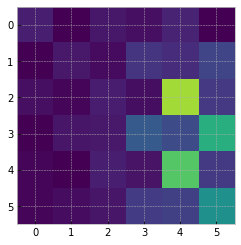

time: 4.64 s


In [14]:
animate_stamp(d0)

In [15]:
def normalize(cube):
    return (cube.T / cube.sum(1)).T

time: 2.12 ms


In [25]:
picid = ticid
psc = observation.get_psc(picid)
# psc[psc == 0] = 1e-10
normalized_psc = normalize(psc)

time: 3.13 ms


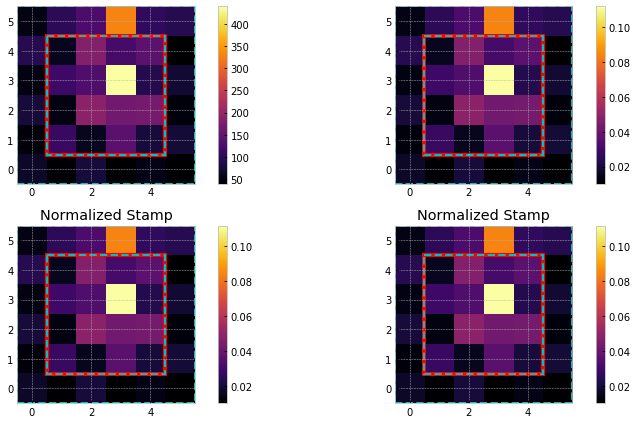

time: 984 ms


In [26]:
# Show best comparison
show_stamps(
    pscs=[
        psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), 
        normalized_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
    ], 
    stamp_size=6, 
    aperture_size=4, 
    frame_idx=0) #, stretch='log')

---

## Get variance

In [18]:
num_refs = 50
d = 0

try:
    diff_group = observation.hdf5_stamps.create_group('diffs')
except ValueError:
    diff_group = observation.hdf5_stamps['diffs']

def normalize(cube):
    return (cube.T / cube.sum(1)).T

def create_diff(picid):
    print("Getting similar sources")
    vary = observation.get_variance_for_target(picid, force_new=True, display_progress=False)
    vary_series = pd.DataFrame({'v': vary}, index=list(observation.stamps.keys())).sort_values(by='v')

    print("Building collection")
    ref_collection = np.array([observation.get_psc(idx) for idx in vary_series.index[:num_refs]])
#     print(ref_collection.shape)

    # Normalize each PSC
    print("Normalizing collection")
    normalized_collection = np.array([normalize(s) for s in ref_collection])

    # Build the coeffs off the normalized PSC
    print("Getting coefficients")
    coeffs = get_ideal_full_coeffs(normalized_collection, damp=d)
#     print(normalized_collection)

    # Build the template from the coeffs with non-normalized data
    print("Building ideal stamp")
    ideal = get_ideal_full_psc(ref_collection, coeffs[0]).reshape(observation.num_frames, -1)

    target_psc = ref_collection[0].reshape(observation.num_frames, -1)

#     diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]

    diff = list()
    for frame_idx in range(observation.num_frames):
        d0 = target_psc[frame_idx].reshape(stamp_size[0], stamp_size[1])
        i0 = ideal[frame_idx].reshape(stamp_size[0], stamp_size[1])
        
        #mean, median, std = sigma_clipped_stats(d0)
        #threshold = median + (5 * std)
        #try:
        #    peak_tbl = find_peaks(d0, threshold)
        #except Exception as e:  # No peaks found
        #    print("Error: ", e)
#                         print("No peak found on {}".format(frame_idx))
        #    continue
    
        #try:
        #    position = (peak_tbl['x_peak'][0], peak_tbl['y_peak'][0])
        #except IndexError:
        #    print("No peaks: ", frame_idx)
        #    continue
        
        #d1 = Cutout2D(d0, position, stamp_size, mode='trim')
        #i1 = Cutout2D(i0, position, stamp_size, mode='trim')
        
        #d2 = d1.data
        #i2 = i1.data
        
        shape = (stamp_size[0] * stamp_size[1])
        div_sum = (d0 / i0).sum() / shape
        diff.append(div_sum)
        
    
    diff_group.create_dataset(picid, data=np.array(diff))
    
    return ideal

time: 12.1 ms


In [ ]:
observation.verbose = False
for picid in tqdm_notebook(observation.stamps.keys()):        
    if picid in diff_group:
        continue

#     psc = observation.get_psc(picid).reshape(observation.num_frames, -1)
#     normalized_psc = normalize(psc)

    create_diff(picid)

observation.verbose = True

In [19]:
try:
    del observation.hdf5_stamps['diffs'][ticid]
except KeyError:
    pass

ideal = create_diff(ticid)

Getting similar sources
Normalizing target for 60 frames
Building collection
Normalizing collection
Getting coefficients
Building ideal stamp
time: 21.7 s


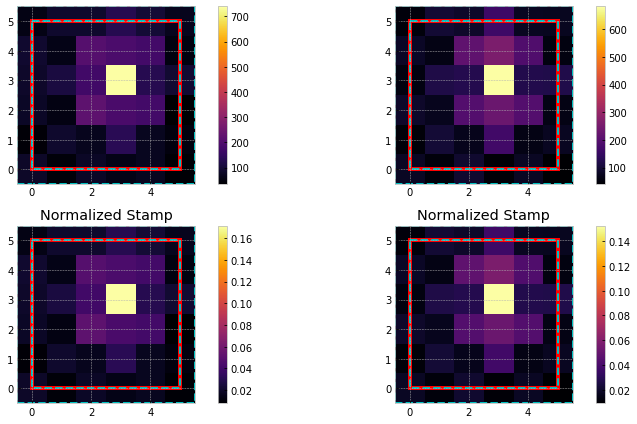

time: 1.02 s


In [67]:
# Show best comparison
show_stamps(pscs=[
            psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]),
            ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
        ], 
        stamp_size=stamp_size[0], 
        aperture_size=stamp_size[0] - 1, 
        frame_idx=1
        ) #, stretch='log')

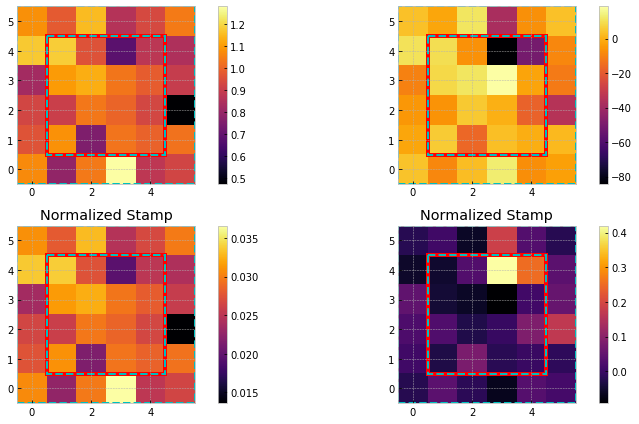

time: 933 ms


In [21]:
# Show best comparison
show_stamps(pscs=[
            psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) / ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]),
            psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) - ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
        ], 
        stamp_size=stamp_size[0], 
        aperture_size=stamp_size[0] - 2, 
        frame_idx=19
        ) #, stretch='log')

In [61]:
from scipy.stats import binned_statistic

time: 1.15 ms


In [62]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

time: 1.82 ms


[-4.76732291e-04  1.00216150e+00]


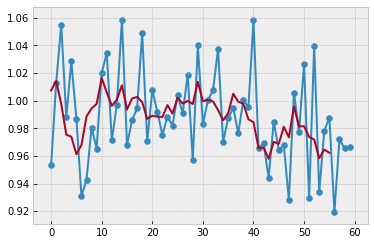

time: 226 ms


In [64]:
y = np.array(observation.hdf5_stamps['diffs'][ticid])
# y = (y - y.mean()) + 1
x = np.arange(len(y))

z = np.polyfit(x, y, 1)
z2 = np.polyfit(x, y, 2)
# print(z)
p = np.poly1d(z)
p2 = np.poly1d(z2)

# plt.plot([p(i) for i in x])
plt.plot(y)
plt.plot(moving_average(y, periods=5), label='ma')
plt.scatter(x, y)
# plt.ylim(0.9, 1.1)
# plt.ylim(0.99, 1.01)
# plt.legend()

In [ ]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(111)

phase = np.arange(observation.num_frames)

for picid in observation.hdf5_stamps['diffs']:
    d0 = np.array(observation.hdf5_stamps['diffs'][picid])
#     d0 = d0 / d0.mean()
#     if d0.max() - d0.min() < .05:
    ax1.plot(d0, label=picid)
    
ax1.hlines(1, phase[0], phase[-1], linestyles='dashed', alpha=0.5)
ax1.hlines(1.01, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')
ax1.hlines(.99, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')

# ax1.legend()
# ax1.set_ylim(-5, 5)
ax1.set_xlim(phase[0], phase[-1])    
fig.savefig('all-the-lines.png')

In [30]:
vary = observation.get_variance_for_target(ticid, force_new=True, display_progress=False)

Normalizing target for 60 frames
time: 22.1 s


In [31]:
vary_series = pd.DataFrame({'v': vary}, index=list(observation.stamps.keys())).sort_values(by='v')

time: 33.9 ms


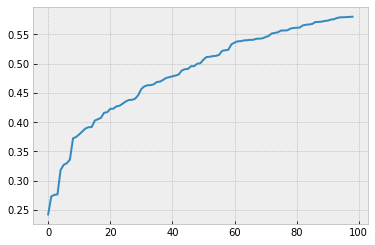

time: 189 ms


In [32]:
plt.plot(vary_series.values[1:100])

In [33]:
vary_series.index

Index(['36734222', '36763899', '36835633', '36824756', '36833808', '36891499',
       '36736409', '36840637', '36881593', '36824402',
       ...
       '54962344', '36893539', '385212359', '36881640', '296844163', '7979428',
       '56665998', '36946585', '56667246', '287047000'],
      dtype='object', length=17267)

time: 5.67 ms


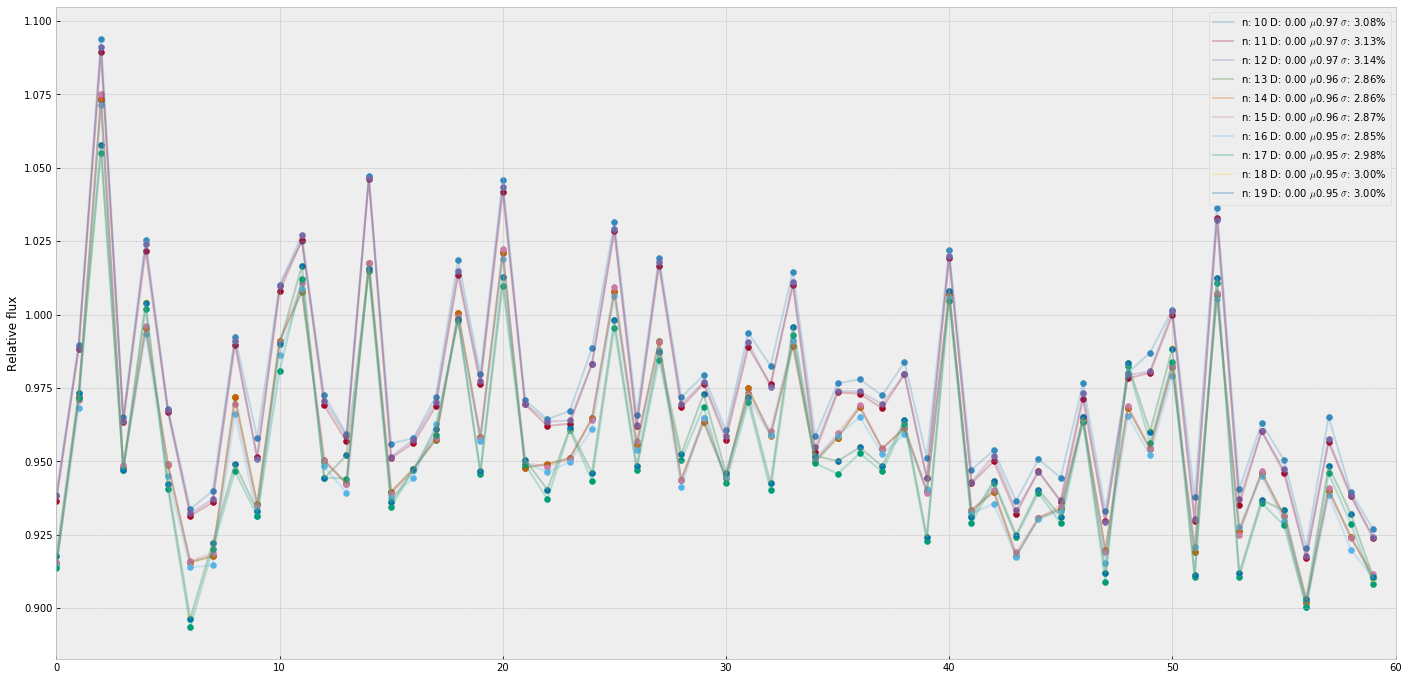

time: 1.64 s


In [43]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(111)

def normalize(cube):
    return (cube.T / cube.sum(1)).T

for num_refs in np.arange(10, 20, 1):
    for d in np.arange(0, 5, 5):
        
        # Get all reference PSC
        stamp_collection = np.array([observation.get_psc(idx) for idx in vary_series.index[:num_refs]])
        # Normalize each PSC
        normalized_collection = np.array([normalize(s) for s in stamp_collection])

        # Build the coeffs off the normalized PSC
        coeffs = get_ideal_full_coeffs(normalized_collection, damp=d)

        # Build the template from the coeffs
        ideal = get_ideal_full_psc(stamp_collection, coeffs[0])

        target_psc = stamp_collection[0]

#         diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]
#         diff = diff / np.median(diff)
        diff = (target_psc.sum(1) / ideal.sum(1))

        mean, median, std = sigma_clipped_stats(diff)

        # Skip those that have a high std
        if std / mean > .05:
            continue

#         ax1.plot(phase, diff, alpha=0.25, label='n: {} D: {:.2f} $\mu$: {:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std / mean))   
        ax1.plot(diff, alpha=0.25, label='n: {} D: {:.2f} $\mu${:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std))   
#         ax1.scatter(phase, diff)   
        ax1.scatter(np.arange(len(diff)), diff)


# plt.plot(diff)
# plt.plot(psc.sum(1) / np.median(psc.sum(1)))

x_min = 0 
x_max = len(diff)
# x_min = phase.min()
# x_max = phase.max()
# ax1.hlines(1, x_min, x_max, linestyles='dashed', alpha=0.5)
# ax1.set_ylim(.8, 1.2)
ax1.set_xlim(x_min, x_max)

# ax1.set_xlabel('Phase')
ax1.set_ylabel('Relative flux')
ax1.legend()

# ax1.set_title("Relative photometry")

In [44]:
num_refs = 16
d = 0.

time: 1.03 ms


In [45]:
ref_collection = np.array([observation.get_psc(idx) for idx in vary_series.index[:num_refs]])
# Normalize each PSC
normalized_collection = np.array([normalize(s) for s in ref_collection])

# Build the coeffs off the normalized PSC
coeffs = get_ideal_full_coeffs(normalized_collection, damp=d)

# Build the template from the coeffs
ideal = get_ideal_full_psc(ref_collection, coeffs[0])

target_psc = ref_collection[0]

time: 15.1 ms


In [46]:
coeffs

(array([ 0.26430243, -0.09475925,  0.08686571,  0.18155007, -0.04226822,
         0.03366902,  0.3471887 , -0.09665845,  0.12697915,  0.03572358,
         0.01096745,  0.17187861,  0.00990454,  0.02431453, -0.04304169]),
 2,
 18,
 0.28314762200660926,
 0.28314762200660926,
 11.237810275861712,
 163.1836291496822,
 4.0062429485745875e-10,
 0.549316416387667,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

time: 3.99 ms


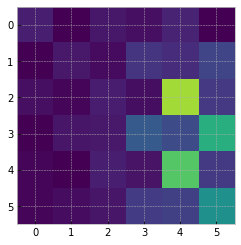

time: 4.77 s


In [47]:
animate_stamp(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[0]))

In [21]:
mean, median, std = sigma_clipped_stats(target_psc, axis=1)
t0 = ((target_psc.T - mean) / std).T

mean, median, std = sigma_clipped_stats(ideal, axis=1)
i0 = ((ideal.T - mean) / std).T

time: 38.6 ms


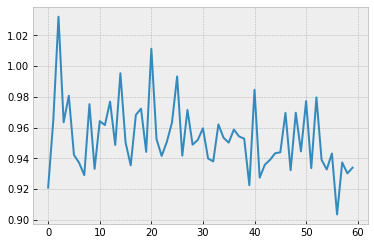

time: 222 ms


In [60]:
plt.plot(target_psc.sum(1) / ideal.sum(1).astype('int'))

(0, 59)

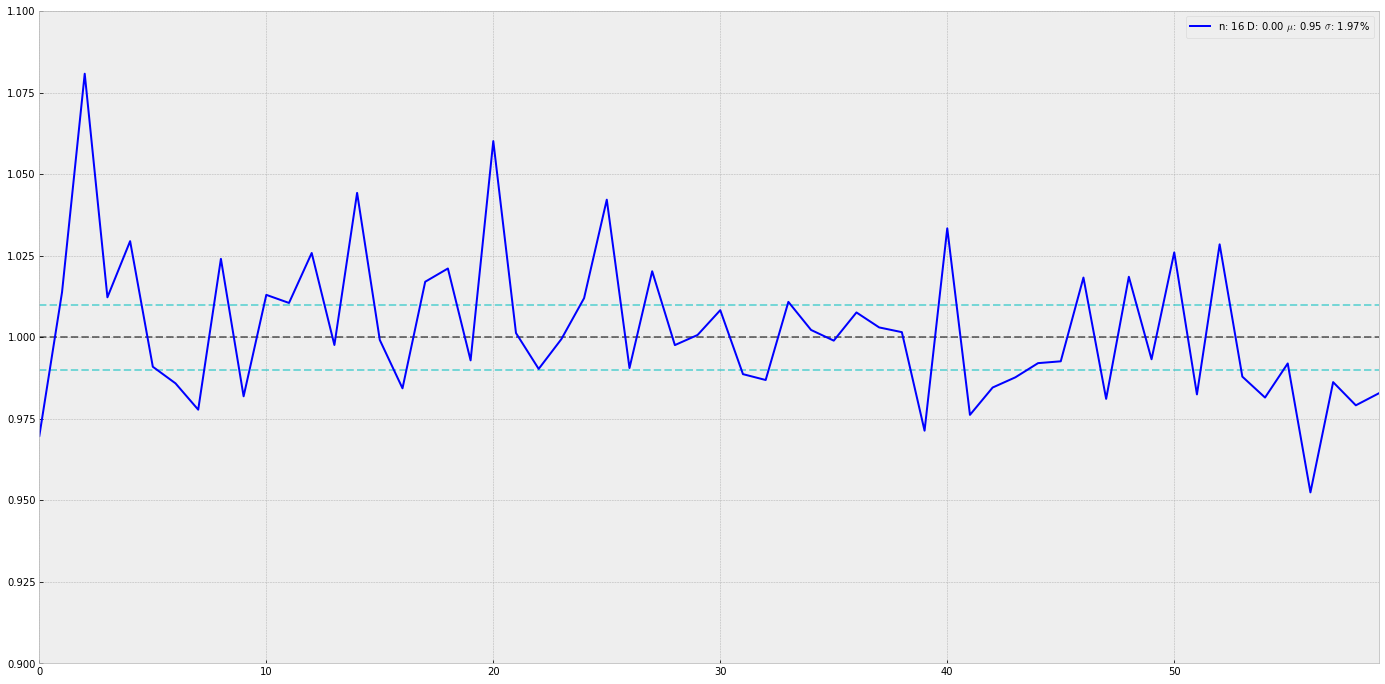

time: 779 ms


In [51]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(111)

phase = np.arange(len(target_psc))

# for i in range(1, 26):
#     diff = (target_psc / observation.get_psc(vary_series.index[i])).sum(1) / target_psc.shape[-1]
#     mean, median, std = sigma_clipped_stats(diff)
#     ax1.plot(phase, diff, color='b', alpha=0.15)   

# for _ in range(10):
#     random_psc = observation.get_psc(ticid=tic_list[np.random.randint(0, len(tic_list))])
#     diff = target_psc.sum(1) / random_psc.sum(1)
#     mean, median, std = sigma_clipped_stats(diff)
#     ax1.plot(phase, diff / mean, alpha=0.1, color='g')   

# diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]
diff = (target_psc.sum(1) / ideal.sum(1))
mean, median, std = sigma_clipped_stats(diff)
# ax1.plot(phase, diff / mean, color='r', lw=4, label='n: {} D: {:.2f} $\mu$: {:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std / mean))       
ax1.plot(phase, diff - mean + 1, color='b', lw=2, label='n: {} D: {:.2f} $\mu$: {:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std / mean))       

ax1.hlines(1, phase[0], phase[-1], linestyles='dashed', alpha=0.5)
ax1.hlines(1.01, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')
ax1.hlines(.99, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')

ax1.legend()
ax1.set_ylim(.9, 1.1)
ax1.set_xlim(phase[0], phase[-1])